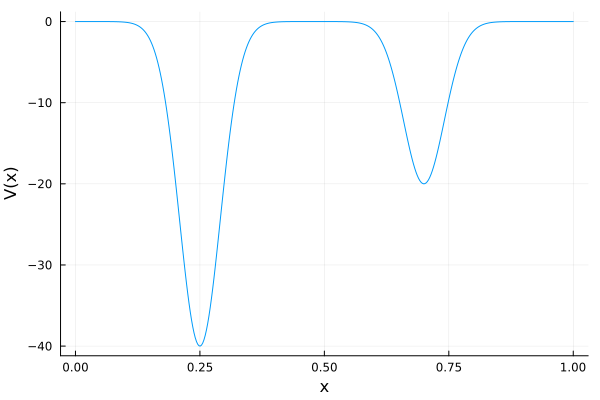

In [231]:
using LinearAlgebra
using SparseArrays
using Plots
using Base.Threads
using Distributed
using IterativeSolvers
using LinearRegression
using LinearMaps
using Arpack

#potentiel
V(x) = -20 * (exp(-30 * cos(pi * (x - 0.20))^2) + 2 * exp(-30 * cos(pi * (x + 0.25))^2))
x_values = range(0, stop=1, length=400)
# Compute V(x) for these x values
y_values = V.(x_values)

# Create the plot
plot(x_values, y_values, xlabel="x", ylabel="V(x)", label="V(x)", legend=false, grid=true)

In [4]:
function projection(P::AbstractMatrix{T}, X::AbstractMatrix{T}) where T
    n = size(P, 1)
    if isa(P, Symmetric{T})
        P = Matrix(P)
    end

    proj = P * X * (I - P) + (I - P) * X * P

    return proj
end


projection (generic function with 1 method)

In [6]:
function construction(Nb)
   x = LinRange(0, 1, Nb)
    diag_V = V.(x)
    main_diag = (1 / dx^2) .+ diag_V
    off_diag = fill(-1 / (2 * dx^2), Nb - 1)

    h = spdiagm(0 => main_diag, 1 => off_diag, -1 => off_diag)
    h[1, Nb] = h[Nb, 1] = -1 / (2 * dx^2)
    return Matrix(h)
end

construction (generic function with 1 method)

In [8]:
function phi(A)
    eigvals, eigvecs = eigen(A)
    sorted_indices = sortperm(eigvals)
    sorted_eigvals = eigvals[sorted_indices]
    sorted_eigvecs = eigvecs[:, sorted_indices]
    sorted_eigvecs[:, 1] /= norm(sorted_eigvecs[:, 1])
    phi= sorted_eigvecs[:, 1] * sorted_eigvecs[:, 1]'
    return phi
end

phi (generic function with 1 method)

In [10]:
function vecteur_propre(A)
    eigvals, eigvecs = eigen(A)
    sorted_indices = sortperm(eigvals)
    sorted_eigvals = eigvals[sorted_indices]
    sorted_eigvecs = eigvecs[:, sorted_indices]
    sorted_eigvecs[:, 1] /= norm(sorted_eigvecs[:, 1])
    phi= sorted_eigvecs
    return phi
end

vecteur_propre (generic function with 1 method)

In [12]:
function retraction(P)
    eigvals, eigvecs = eigen(P)
    D = diagm(eigvals)
    phi=eigvecs
    for j in 1:size(P, 1)
        if abs(D[j, j]) > 0.5
            D[j, j] = 1.0
        else
            D[j, j] = 0.0
        end
    end

    P_retracted = phi * D * phi'
    return P_retracted
end


retraction (generic function with 1 method)

In [14]:
function Point_fixe(Nb, alpha, beta, max_iter, tolerance)
    dx = 1 / Nb
    h = construction(Nb)
    P_old = phi(h)
    s = []
    erreur = []

    for k in 1:max_iter
        H = h + (alpha / dx) * diagm(diag(P_old))
        P_new = phi(H)
        push!(s, k)
        push!(erreur, norm(P_new - P_old))

        # Vérification de la convergence
        if norm(P_new - P_old) < tolerance
            println("Convergence atteinte après $k itérations.")
            return P_old, s, erreur
            break
        end

        P_old = beta * P_new + (1 - beta) * P_old
    end

    println("Nombre maximum d'itérations atteint.")
    return P_old, s, erreur
end

Point_fixe (generic function with 1 method)

In [16]:
function point_fix(alpha, beta,Nb,max_iterations,tolerance)
    dx = 1 / Nb
    h = construction(Nb)
    P_old = phi(h)
    for k in 1:max_iterations
        H = h + (alpha / dx) * spdiagm(0 => diag(P_old)) 
        P_new = beta * phi(H) + (1 - beta) * P_old
        error = norm(P_new - P_old)
        if error < tolerance
            return k
        end
        P_old=P_new
    end
    return max_iterations
end

point_fix (generic function with 1 method)

In [18]:
function plot_pointfixe(Nb, alpha, beta, max_iter, tolerance, title)
    P_final, iterations, erreurs = Point_fixe(Nb, alpha, beta, max_iter, tolerance)
    plot1 = plot(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur", title="Convergence de l'algorithme $title", yscale=:log10, lw=2)
    dx = 1 / Nb
    x_values = [(i-1)*dx for i in 1:Nb]
    y_values = [P_final[i, i] / dx for i in 1:Nb]
    plot2 = plot(x_values, y_values, label="P(x)", xlabel="x", ylabel="P(x)/dx")
    z_values = [V(x_values[i]) + alpha * (P_final[i, i] / dx) for i in 1:Nb]
    plot3 = plot(x_values, z_values, label="Veff", xlabel="x", ylabel="Veff(x)")
    display(plot1)
    #display(plot2)
    #display(plot3)
end

plot_pointfixe (generic function with 1 method)

In [70]:
function SCF(Nb, alpha, beta, max_iter, tolerance)
h=construction(Nb)
P_old=phi(h)
   #= P_perturb=Symmetric(rand(Nb,Nb))
    P_perturb/=10*norm(P_perturb)
    P_old=retraction(P_old+P_perturb)=#
s = []
erreur = []

for k in 1:max_iter
    H = h + (alpha / dx) * diagm(diag(P_old))
    P_new = P_old + beta * projection(P_old, phi(H) - P_old)
    P_new=Symmetric(P_new)
    P_new=retraction(P_new)
    push!(s,k)
    push!(erreur, norm(P_new-P_old))
    # Vérification de la convergence
    if norm(P_new-P_old) < tolerance
        #println("Convergence atteinte après $k itérations.")
            return P_old, s, erreur
                    break

    end
    P_old=P_new
end
#println("Nombre maximum d'itérations atteint.")
    return P_old, s, erreur
end



SCF (generic function with 1 method)

In [116]:
function SCF_pas_variable(Nb, alpha, max_iter, tolerance)
h=construction(Nb)
P_old=phi(h)
   #= P_perturb=Symmetric(rand(Nb,Nb))
    P_perturb/=10*norm(P_perturb)
    P_old=retraction(P_old+P_perturb) =#
s = []
erreur = []
for k in 1:max_iter
    H = h + (alpha / dx) * diagm(diag(P_old))
    F_k=projection(P_old, phi(H) - P_old)
    #=    H_k=h + (alpha / dx) * diagm(diag(F_k))
    F_2k=phi(F_k)
    delta_k=F_2k-2*F_k+P_old
    beta=tr(delta_k*(F_k-P_old)')/norm(delta_k)^2=#
        beta=-(tr(h*F_k*P_old)+(alpha/(2*dx))*sum(P_old[i,i]*F_k[i,i] for i in 1:Nb))/(tr(h*F_k^2)+(alpha/(2*dx))*sum(F_k[i,i]^2 for i in 1:Nb))
    P_new = P_old + beta * projection(P_old, phi(H) - P_old)
    P_new=Symmetric(P_new)
    P_new=retraction(P_new)
    push!(s,k)
    push!(erreur, norm(P_new-P_old))
    # Vérification de la convergence
    if norm(P_new-P_old) < tolerance
        #println("Convergence atteinte après $k itérations.")
            return P_old, s, erreur
                    break

    end
    P_old=P_new
end
#println("Nombre maximum d'itérations atteint.")
    return P_old, s, erreur
end

SCF_pas_variable (generic function with 1 method)

In [211]:
function SCF_pas_variable2(Nb, alpha, max_iter, tolerance)
h=construction(Nb)
P_old=phi(h)
   #= P_perturb=Symmetric(rand(Nb,Nb))
    P_perturb/=10*norm(P_perturb)
    P_old=retraction(P_old+P_perturb) =#
s = []
erreur = []
for k in 1:max_iter
    H = h + (alpha / dx) * diagm(diag(P_old))
    F_k=phi(H)
        H_k=h + (alpha / dx) * diagm(diag(F_k))
    F_2k=phi(H_k)
    delta_k=F_2k-2*F_k+P_old
    beta=-tr(delta_k*(F_k-P_old)')/norm(delta_k)^2
    P_new = P_old + beta * projection(P_old, phi(H) - P_old)
    P_new=Symmetric(P_new)
    P_new=retraction(P_new)
    push!(s,k)
        H_new=h + (alpha / dx) * diagm(diag(P_new))
    push!(erreur, norm(P_new-phi(H_new)))
    # Vérification de la convergence
    if norm(P_new-P_old) < tolerance
        #println("Convergence atteinte après $k itérations.")
            return P_old, s, erreur
                    break

    end
    P_old=P_new
end
#println("Nombre maximum d'itérations atteint.")
    return P_old, s, erreur
end

SCF_pas_variable2 (generic function with 1 method)

In [159]:
function SCF_pas_random(Nb, alpha, max_iter, tolerance)
h=construction(Nb)
P_old=phi(h)
   #= P_perturb=Symmetric(rand(Nb,Nb))
    P_perturb/=10*norm(P_perturb)
    P_old=retraction(P_old+P_perturb) =#
s = []
erreur = []
for k in 1:max_iter
    H = h + (alpha / dx) * diagm(diag(P_old))
    F_k=projection(P_old, phi(H) - P_old)
        beta=-(0.5+rand())*(tr(h*F_k*P_old)+(alpha/(2*dx))*sum(P_old[i,i]*F_k[i,i] for i in 1:Nb))/(tr(h*F_k^2)+(alpha/(2*dx))*sum(F_k[i,i]^2 for i in 1:Nb))
    P_new = P_old + beta * projection(P_old, phi(H) - P_old)
    P_new=Symmetric(P_new)
    P_new=retraction(P_new)
    push!(s,k)
    push!(erreur, norm(P_new-P_old))
    # Vérification de la convergence
    if norm(P_new-P_old) < tolerance
        #println("Convergence atteinte après $k itérations.")
            return P_old, s, erreur
                    break

    end
    P_old=P_new
end
#println("Nombre maximum d'itérations atteint.")
    return P_old, s, erreur
end



SCF_pas_random (generic function with 1 method)

In [26]:
function gradient_descent(Nb, alpha, beta, max_iterations, tolerance)
    dx = 1 / Nb
    h = construction(Nb)
    P_old = phi(h)
    P_new = zeros(Nb,Nb)
    s = []
    erreur = []
    for k in 1:max_iterations
        H = h + (alpha / dx) * diagm(diag(P_old))
        P_new = P_old - beta * projection(P_old,H)
        P_new=Symmetric(P_new)
        P_new = retraction(P_new)
        push!(s,k)
        push!(erreur, norm(P_new - P_old))
        # Vérification de la convergence
        if norm(P_new - P_old) < tolerance
            println("Convergence atteinte après $k itérations.")
                 return P_new, s, erreur
            break
        end
        P_old=P_new
    end
return P_new, s, erreur
end

gradient_descent (generic function with 1 method)

In [175]:
function gradient_descent_variable(Nb, alpha, max_iterations, tolerance)
    dx = 1 / Nb
    h = construction(Nb)
    P_old = phi(h)
    P_new = zeros(Nb,Nb)
    s = []
    erreur = []
    for k in 1:max_iterations
        H = h + (alpha / dx) * diagm(diag(P_old))
        proj=projection(P_old,H)
        beta=(tr(h*P_old*proj)+(alpha/(2*dx))*sum(P_old[i,i]*proj[i,i] for i in 1:Nb))/(tr(h*proj^2)+(alpha/(2*dx))*sum(proj[i,i]^2 for i in 1:Nb))
        P_new = P_old - beta * projection(P_old,H)
        P_new=Symmetric(P_new)
        P_new = retraction(P_new)
        push!(s,k)
        push!(erreur, norm(P_new - P_old))
        # Vérification de la convergence
        if norm(P_new - P_old) < tolerance
         println("Convergence atteinte après $k itérations.")
                 return P_new, s, erreur
            break
        end
        P_old=P_new
    end
return P_new, s, erreur
end

gradient_descent_variable (generic function with 1 method)

In [167]:
function gradient_descent_random(Nb, alpha, max_iterations, tolerance)
    dx = 1 / Nb
    h = construction(Nb)
    P_old = phi(h)
    P_new = zeros(Nb,Nb)
    s = []
    erreur = []
    for k in 1:max_iterations
        H = h + (alpha / dx) * diagm(diag(P_old))
        proj=projection(P_old,H)
        beta=2*rand()*(tr(h*P_old*proj)+(alpha/(2*dx))*sum(P_old[i,i]*proj[i,i] for i in 1:Nb))/(tr(h*proj^2)+(alpha/(2*dx))*sum(proj[i,i]^2 for i in 1:Nb))
        P_new = P_old + beta * projection(P_old,H)
        P_new=Symmetric(P_new)
        P_new = retraction(P_new)
        push!(s,k)
        push!(erreur, norm(P_new - P_old))
        # Vérification de la convergence
        if norm(P_new - P_old) < tolerance
         #println("Convergence atteinte après $k itérations.")
                 return P_new, s, erreur
            break
        end
        P_old=P_new
    end
return P_new, s, erreur
end

gradient_descent_random (generic function with 1 method)

In [32]:
function gradient_barzilai(Nb, alpha, beta, max_iter, tolerance)
    dx = 1 / Nb
    h = construction(Nb)
    P_old = phi(h)
    s = []
    erreur = []
    beta_k=[beta]
    for k in 1:max_iter
        H = h + (alpha / dx) * diagm(diag(P_old))
        P_new = phi(H)
        P_new = P_old - beta * projection(P_old,H)
        P_new=Symmetric(P_new)
        P_new=retraction(P_new)
        beta=(norm(P_new-P_old)^2)/tr((P_new-P_old)*(projection(P_new,h + (alpha / dx) * diagm(diag(P_new)))-projection(P_old,H))')
        push!(beta_k,beta)
        push!(s, k)
        push!(erreur, norm(P_new - P_old))

        # Vérification de la convergence
        if norm(P_new - P_old) < tolerance
            println("Convergence atteinte après $k itérations.")
            return P_old, s, erreur,beta_k
        end
       
        P_old = P_new
    end

    println("Nombre maximum d'itérations atteint.")
    return P_old, s, erreur,beta_k
end

gradient_barzilai (generic function with 1 method)

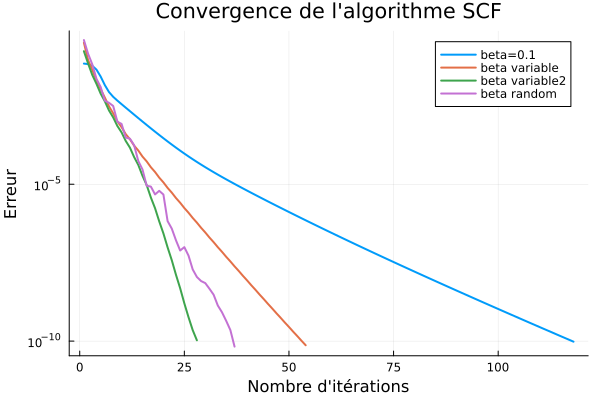

In [213]:
Nb = 100
dx = 1 / Nb
alpha = 50
beta=0.1
max_iter = 1000
tolerance = 1e-10
    P_final, iterations, erreurs = SCF(Nb, alpha, beta, max_iter, tolerance) 
    plot(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur",label="beta=$beta", title="Convergence de l'algorithme SCF", yscale=:log10, lw=2)
    P_final2, iterations2, erreurs2 = SCF_pas_variable(Nb, alpha, max_iter, tolerance) 
    plot!(iterations2, erreurs2, xlabel="Nombre d'itérations", ylabel="Erreur",label="beta variable", yscale=:log10, lw=2)
    P_final3, iterations3, erreurs3 = SCF_pas_variable2(Nb, alpha, max_iter, tolerance) 
    plot!(iterations3, erreurs3, xlabel="Nombre d'itérations", ylabel="Erreur",label="beta variable2", yscale=:log10, lw=2)
    P_final4, iterations4, erreurs4 = SCF_pas_random(Nb, alpha, max_iter, tolerance) 
    plot!(iterations4, erreurs4, xlabel="Nombre d'itérations", ylabel="Erreur",label="beta random", yscale=:log10, lw=2)

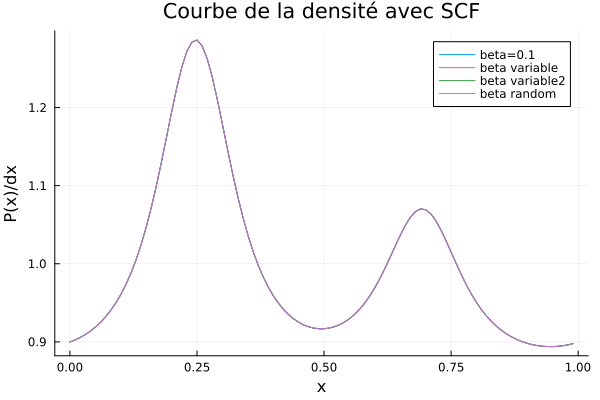

In [187]:
dx = 1 / Nb
    x_values = [(i-1)*dx for i in 1:Nb]
    y_values = [P_final[i, i] / dx for i in 1:Nb]
    y_values2 = [P_final2[i, i] / dx for i in 1:Nb]
    y_values3 = [P_final3[i, i] / dx for i in 1:Nb]
    y_values4 = [P_final4[i, i] / dx for i in 1:Nb]

plot(x_values, y_values, xlabel="x", ylabel="P(x)/dx",label="beta=0.1",title="Courbe de la densité avec SCF")
plot!(x_values, y_values2, xlabel="x", ylabel="P(x)/dx",label="beta variable")
plot!(x_values, y_values3, xlabel="x", ylabel="P(x)/dx",label="beta variable2")
plot!(x_values, y_values4, xlabel="x", ylabel="P(x)/dx",label="beta random")

Convergence atteinte après 2724 itérations.
Convergence atteinte après 1139 itérations.


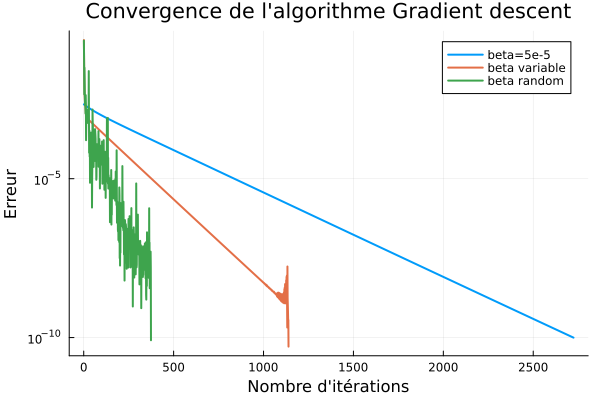

In [48]:
Nb = 100
dx = 1 / Nb
alpha = 50
beta = 5e-5
max_iter = 4000
tolerance = 1e-10
title="Gradient descent"
    P_final, iterations, erreurs = gradient_descent(Nb, alpha, beta, max_iter, tolerance)
    plot(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur",label="beta=5e-5", title="Convergence de l'algorithme $title", yscale=:log10, lw=2)
    P_final2, iterations2, erreurs2 = gradient_descent_variable(Nb, alpha, max_iter, tolerance)
    plot!(iterations2, erreurs2, xlabel="Nombre d'itérations", ylabel="Erreur",label="beta variable", yscale=:log10, lw=2)
    P_final3, iterations3, erreurs3 = gradient_descent_random(100, 50, 2000, 1e-10) 
    plot!(iterations3, erreurs3, xlabel="Nombre d'itérations", ylabel="Erreur",label="beta random", yscale=:log10, lw=2)

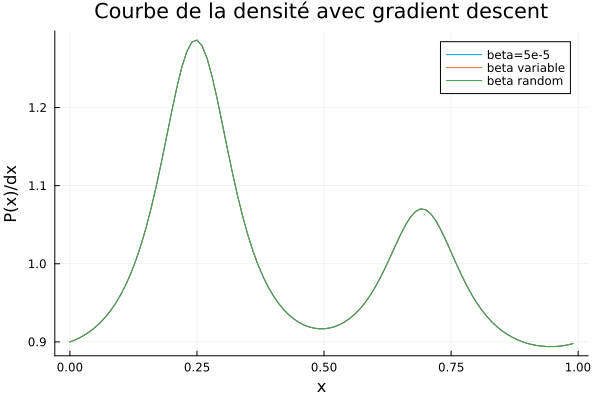

In [56]:
    x_values = [(i-1)*dx for i in 1:Nb]
    y_values = [P_final[i, i] / dx for i in 1:Nb]
    y_values2 = [P_final2[i, i] / dx for i in 1:Nb]
    y_values3 = [P_final3[i, i] / dx for i in 1:Nb]
    plot(x_values, y_values, label="beta=5e-5", xlabel="x", ylabel="P(x)/dx",title="Courbe de la densité avec gradient descent")
    plot!(x_values, y_values2, label="beta variable", xlabel="x", ylabel="P(x)/dx")
    plot!(x_values, y_values3, label="beta random", xlabel="x", ylabel="P(x)/dx")


convergence moyenne en 230 itérations


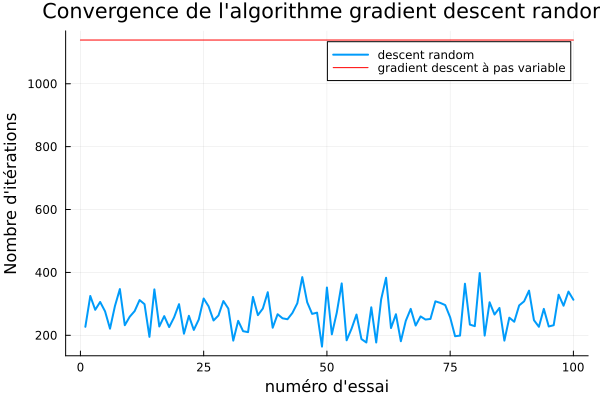

In [81]:
using Base.Threads
using Distributed
s=[]
@threads for i in 1:100
    P_final, iterations, erreurs = gradient_descent_random(100, 50, 2000, 1e-10) 
    push!(s,iterations[end])
end
println("convergence moyenne en $(iterations[end]) itérations")
plot(1:1:100,s,xlabel="numéro d'essai", ylabel="Nombre d'itérations", title="Convergence de l'algorithme gradient descent random",label=" descent random",lw=2)
plot!([0, 100], [1139, 1139], color="red", label=" gradient descent à pas variable")

In [235]:
using Base.Threads
using Distributed
alpha_values = 2:2:50
beta_values = 0.01:0.02:1.6
iterations = zeros(length(alpha_values), length(beta_values))
@threads for i in 1:length(alpha_values)
    alpha = alpha_values[i]
    for j in 1:length(beta_values)
        beta = beta_values[j]
        S=SCF(10, alpha, beta, 1000, 1e-12)[2]
        iterations[i, j] = S[end] 

    end
end

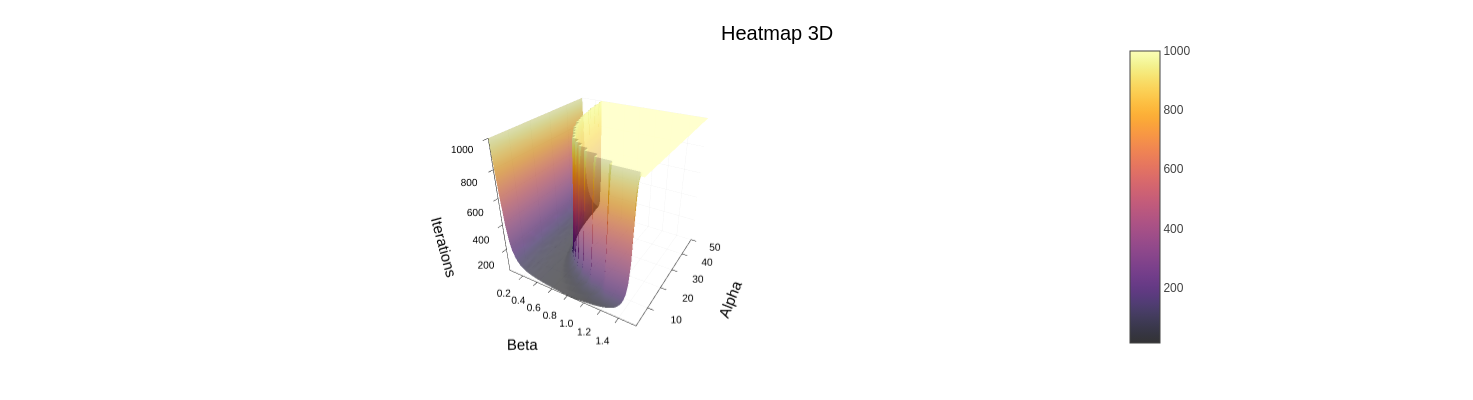

In [90]:
plotlyjs()
# Affichage de la heatmap en 3D avec surface()
surface(beta_values, alpha_values , iterations, opacity=0.8, xlabel="Beta", ylabel="Alpha", zlabel="Iterations", title="Heatmap 3D")

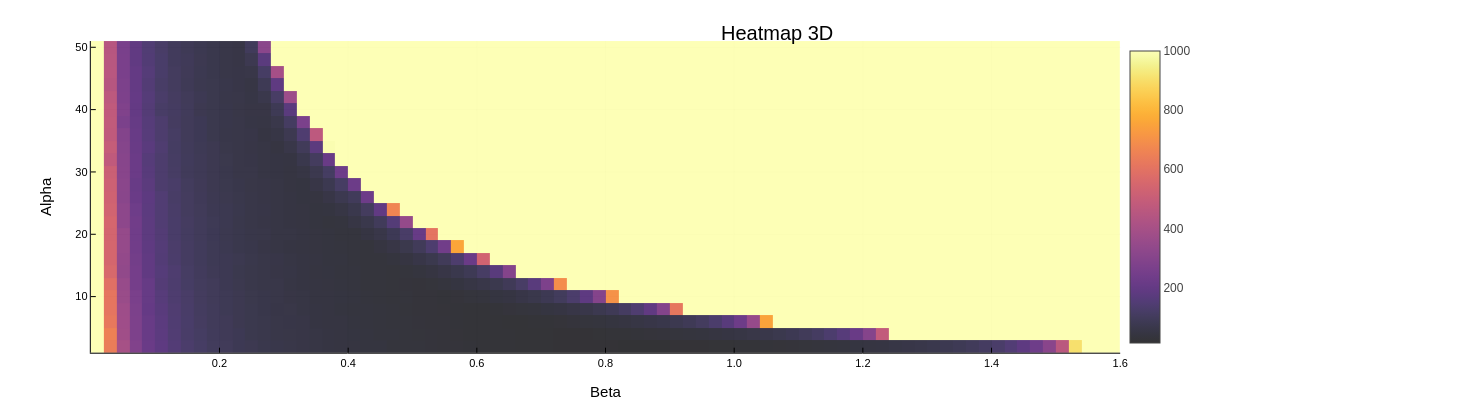

In [92]:
heatmap_plot=heatmap(beta_values, alpha_values , iterations, opacity=0.8, xlabel="Beta", ylabel="Alpha", zlabel="Iterations", title="Heatmap 3D")

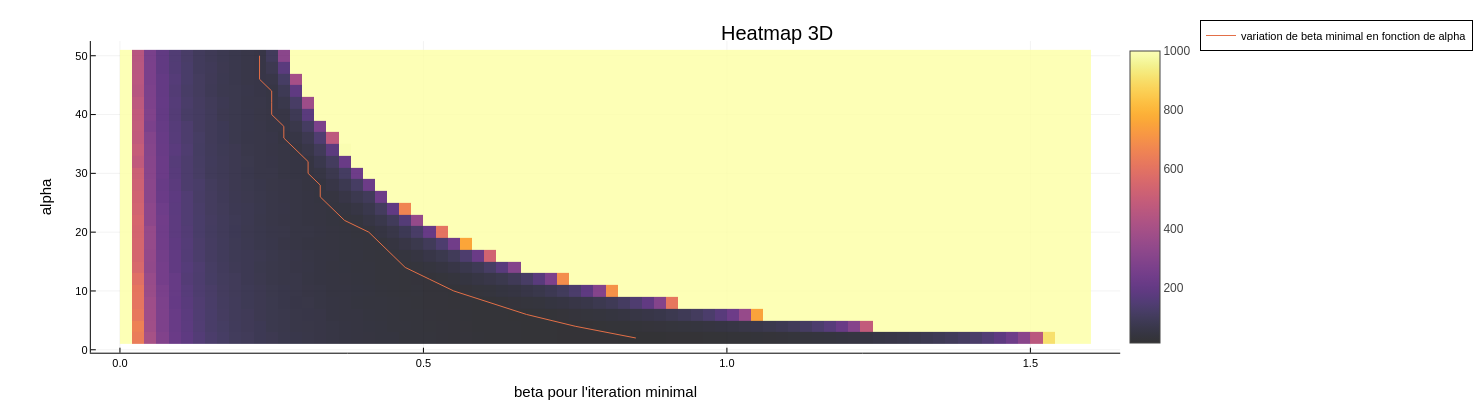

In [94]:
B=[]
for i in 1:length(alpha_values)
    beta_min_indices = argmin(iterations[i, :])
    beta_min=beta_values[beta_min_indices]
    push!(B,beta_min)
end
Bb=B
aa=alpha_values
plot!(Bb,aa, xlabel="beta pour l'iteration minimal",ylabel="alpha",label="variation de beta minimal en fonction de alpha")

In [233]:
plot(Bb,aa, xlabel="beta ",ylabel="alpha",label="Variation du coefficient beta correspondant à l'itération minimale en fonction de l'alpha")

LoadError: UndefVarError: `Bb` not defined

In [227]:
function omega(X::AbstractMatrix{T}, P::AbstractMatrix{T}, H::AbstractMatrix{T}) where T #calcul de l'operateur matricielle omega
    X = projection(P, X)
    om = P * X * (I - P) * H - H * P * X * (I - P)
    omega = om + om'
    return projection(P, omega)
end
function K(P::AbstractMatrix{T}, X::AbstractMatrix{T},alpha,dx) where T #Calcul e la matrice hessienn
    X=projection(P,X)
    k=(alpha/dx)*diagm(diag(X))
    k=projection(P,k)
    return k
end
function J_map(P_star,H)    #fonction qui calcul la jacobienne du gradient descent et SCF
    n = size(P_star, 1)
    J_gradient = x -> begin
        X = reshape(x, n, n)
        X = projection(P_star, X)
        J_K = omega(X, P_star, H) + K(P_star, X,alpha,dx)
        J_K = projection(P_star,J_K)
        vec(J_K)  # Convertir la matrice résultante en vecteur
    end
    omega_func = x -> begin
        X = reshape(x, n, n)
        X = projection(P_star, X)
        omega_k = omega(X, P_star, H)
        omega_k = projection(P_star,omega_k)
        vec(omega_k)  
    end
    
    omega_map = LinearMap(omega_func, n^2)
    J_gradient_map = LinearMap(J_gradient, n^2)
    J_SCF = x -> begin
        X = reshape(x, n, n)
        K_X = K(P_star, X, alpha, dx)
        K_X_vec = vec(K_X)
        y=gmres(omega_map, K_X_vec)
        Y=reshape(y,n,n)
        y=vec(projection(P_star,Y))
        y = y + x  
    end
    J_map_SCF = LinearMap(J_SCF, n^2)
    return J_map_SCF,J_gradient_map
end
function beta_optim(A,n)
    lambda_max_list = eigs(A, nev=1, which=:LR, tol=1e-10,maxiter=100000)[1]
    lambda_max_scf=norm(lambda_max_list)
    lambda_min_list = eigs(A, nev=n, which=:SR, tol=1e-10,maxiter=10000)[1]
    lambda_min_scf=0
    for i in 1:length(lambda_min_list)
        if norm(lambda_min_list[i])>1+1e-3
            lambda_min_scf=norm(lambda_min_list[i])
            break
        end
    end
    beta_optimal_scf=2/(lambda_max_scf+lambda_min_scf)
end

beta_optim (generic function with 1 method)

In [229]:
alpha_values = 2:2:50
Nb = 10
dx = 1 / Nb
beta_list=[]
for i in 1:length(alpha_values)
    alpha = alpha_values[i]
beta = 0.2
tolerance = 1e-12
h=construction(Nb)
P_init=phi(h)
P_star=SCF(Nb, alpha, beta, 5000, 1e-12)[1]
H = h + (alpha / dx) * diagm(diag(P_star))
Jacobienne= J_map(P_star,H)[1]
beta_optimal_scf=beta_optim(Jacobienne,98)
push!(beta_list,beta_optimal_scf)
end

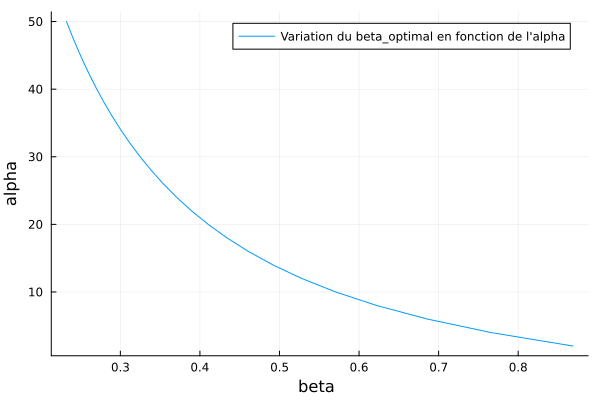

In [225]:
plot(beta_list,alpha_values, xlabel="beta ",ylabel="alpha",label="Variation du beta_optimal en fonction de l'alpha")

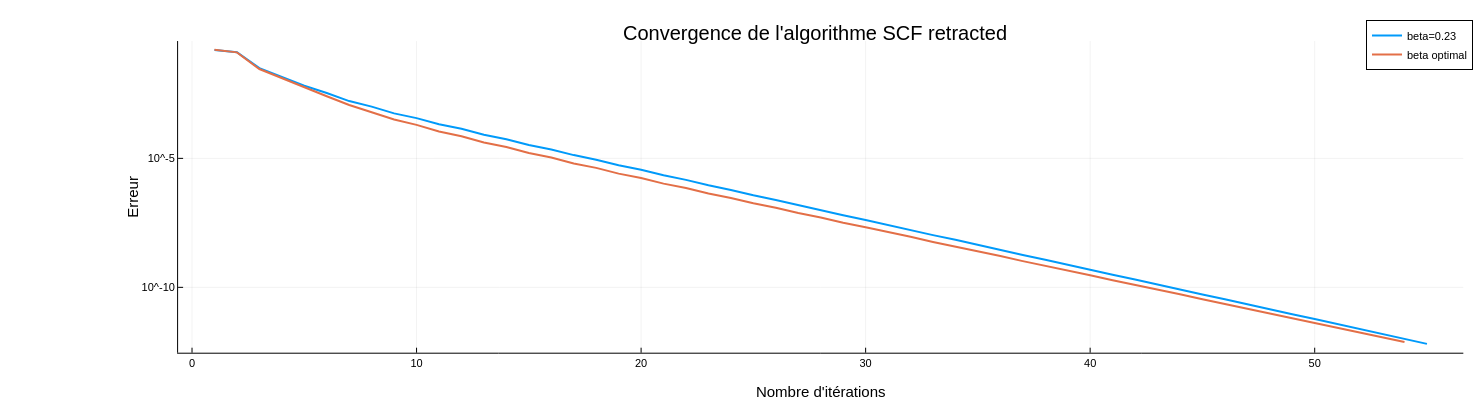

In [102]:
P,s,erreur=SCF(10, 50, 0.23, 5000, 1e-12)
plot(s, erreur, xlabel="Nombre d'itérations", ylabel="Erreur",label="beta=0.23", yscale=:log10,color=1, lw=2)
P,s,erreur=SCF(10, 50, 0.23229,5000, 1e-12)
plot!(s, erreur, xlabel="Nombre d'itérations", ylabel="Erreur", title="Convergence de l'algorithme SCF retracted  ",label="beta optimal", yscale=:log10,color=2, lw=2)

In [56]:
using Arpack
lambda_max = eigs(J_gradient_map, nev=1, which=:LR, tol=1e-12)[1]
lambda_max=norm(lambda_max)
lambda_min_list = eigs(J_gradient_map, nev=7, which=:SR, tol=1e-12,maxiter=3000)[1]
lambda_min=0
for i in 1:length(lambda_min_list)
    if norm(lambda_min_list[i])>1e-3
        lambda_min=norm(lambda_min_list[i])
        break
    end
end
beta_optimal=2/(lambda_max+lambda_min)
println("lambda_min =",lambda_min)
println("lambda_max =",lambda_max)
println("beta_optimal =",beta_optimal)

lambda_min =115.86485085269489
lambda_max =20102.162396242846
beta_optimal =9.892161958023445e-5


Convergence atteinte après 1430 itérations.
Convergence atteinte après 152 itérations.
Convergence atteinte après 1139 itérations.


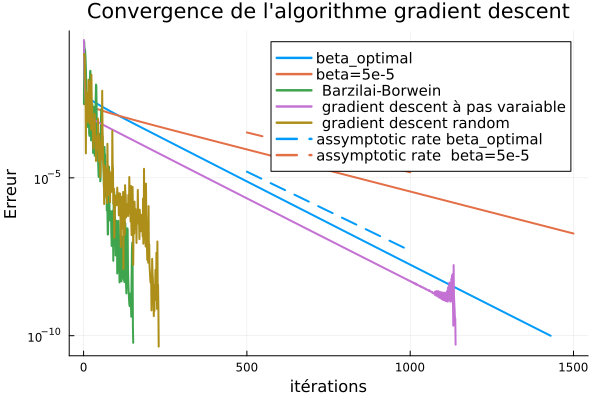

In [79]:
Nb = 100
alpha = 50
max_iter = 1500
tolerance = 1e-10
title = "gradient descent"
Pinit=vecteur_propre(H)
Pinit=Pinit[:,Nb]*Pinit[:,Nb]'
tr(Pinit)
Pinit=phi(h)

    P_final, iterations, erreurs = gradient_descent(Nb, alpha, beta_optimal, max_iter, tolerance)
    plot(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur", title="Convergence de l'algorithme $title",label="beta_optimal", yscale=:log10,color=1, lw=2)

    P_final, iterations, erreurs = gradient_descent(Nb, alpha, 5e-5, max_iter, tolerance)
    plot!(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur", title="Convergence de l'algorithme $title",label="beta=5e-5", yscale=:log10, color=2,lw=2)

    P_final, iterations, erreurs = gradient_barzilai(Nb, alpha, 5e-5, max_iter, tolerance)
    plot!(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur", title="Convergence de l'algorithme $title",label=" Barzilai-Borwein", yscale=:log10, lw=2)

    P_final, iterations, erreurs = gradient_descent_variable(Nb, alpha, max_iter, tolerance)
    plot!(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur", title="Convergence de l'algorithme $title",label=" gradient descent à pas varaiable", yscale=:log10, lw=2)

    P_final, iterations, erreurs = gradient_descent_random(Nb, alpha, max_iter, tolerance)
    plot!(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur", title="Convergence de l'algorithme $title",label=" gradient descent random", yscale=:log10, lw=2)

    r_opt=max(abs(1-beta_optimal*lambda_max),abs(1-beta_optimal*lambda_min))
    r_1=max(abs(1-(5e-5)*lambda_max),abs(1-(5e-5)*lambda_min))
    YY_opt=[0.005*r_opt^(i) for i in 500:1:1000]
    YY_1=[0.005*r_1^i for i in 500:1:1000]
    plot!(500:1:1000 , YY_opt,xlabel="itérations",ylabel="assymptotique rate",label="assymptotic rate beta_optimal", yscale=:log10,color=1,linestyle=:dash, lw=2)
    plot!(500:1:1000 , YY_1,xlabel="itérations",ylabel="Erreur",label="assymptotic rate  beta=5e-5", yscale=:log10,color=2,legendfontsize=10,linestyle=:dash, lw=2)
    #savefig("gdnonlin.pdf") 

Convergence atteinte après 86 itérations.


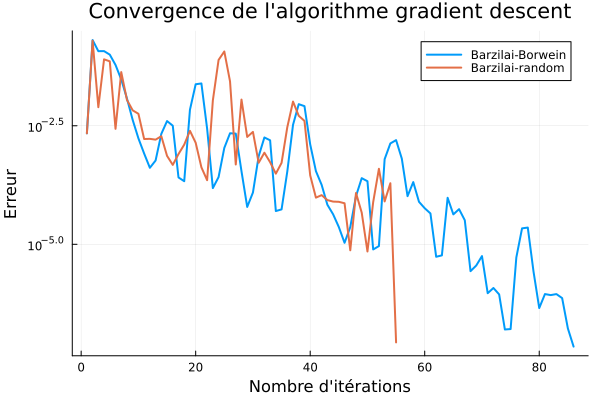

In [143]:
    P_final, iterations, erreurs = gradient_barzilai(Nb, alpha, 5e-5, max_iter, 1e-7)
    plot(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur",label=" Barzilai-Borwein", title="Convergence de l'algorithme $title", yscale=:log10, lw=2)
    P_final, iterations, erreurs = gradient_barzilai_prob(Nb, alpha, 5e-5, max_iter, 1e-7)
    plot!(iterations, erreurs, xlabel="Nombre d'itérations", ylabel="Erreur", label=" Barzilai-random", yscale=:log10, lw=2)